In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('MetroPT2.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df.reset_index(drop=True, inplace=True)

# Investigate the 3 errors in the test set
Maybe we are able to form another hypothesis, based on all channels (not just analog) on what (in combination with Flowmeter) is indicative of errors

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

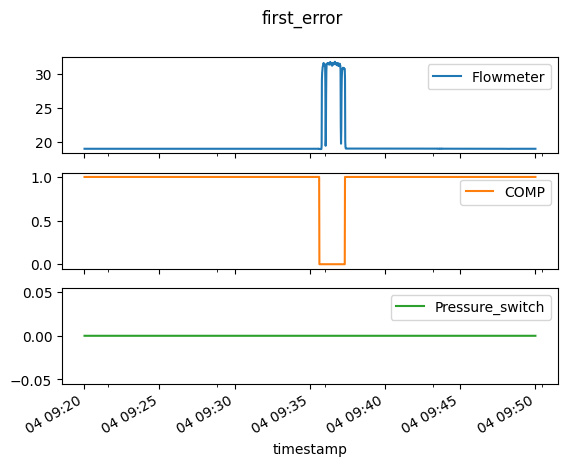

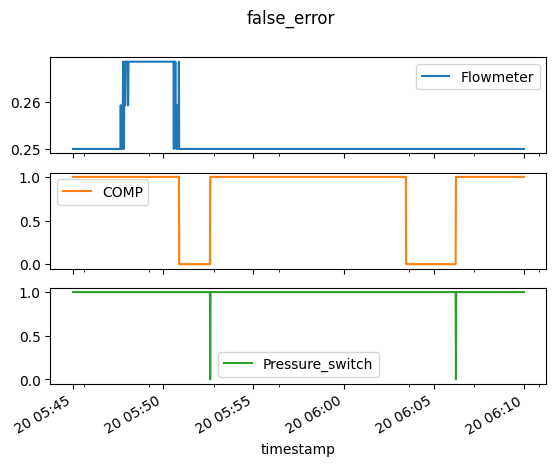

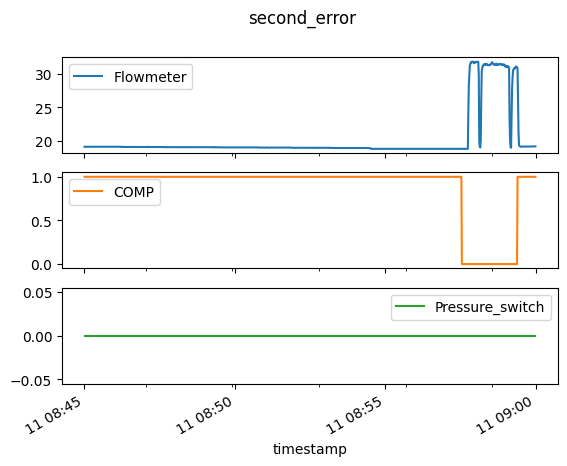

In [3]:

first_error = df[(df['timestamp'] >= np.datetime64('2022-06-04T09:20:00.000000000')) & (df['timestamp'] <= np.datetime64('2022-06-04T09:50:00.000000000'))]
first_error[['timestamp', 'Flowmeter', 'COMP', 'Pressure_switch']].plot(x='timestamp', subplots=True, title='first_error')

false_error = df[(df['timestamp'] >= np.datetime64('2022-06-20T05:45:00.000000000')) & (df['timestamp'] <= np.datetime64('2022-06-20T06:10:00.000000000'))]
false_error[['timestamp', 'Flowmeter', 'COMP', 'Pressure_switch']].plot(x='timestamp', subplots=True, title='false_error')

second_error = df[(df['timestamp'] >= np.datetime64('2022-07-11T08:45:00.000000000')) & (df['timestamp'] <= np.datetime64('2022-07-11T09:00:00.000000000'))]
second_error[['timestamp', 'Flowmeter', 'COMP', 'Pressure_switch']].plot(x='timestamp', subplots=True, title='second_error')


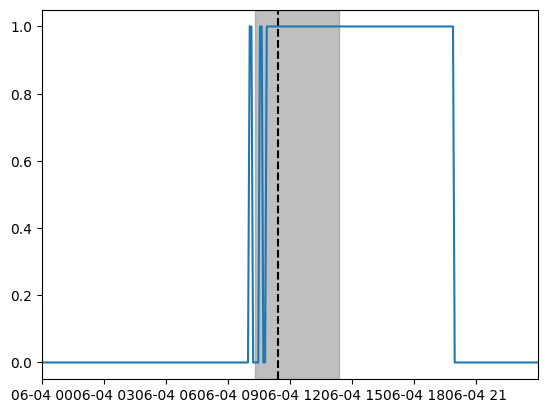

In [11]:
test = df.copy()
test['hypo'] = ((test['COMP'] == 0) & (test['Pressure_switch'] == 0)).astype(np.int8)
#test.plot(x='timestamp', y='hypo')
from tsx.datasets import windowing
from failure_detection import simple_lowpass_filter
pred, _ = windowing(test['hypo'].to_numpy(), L=300, H=1, z=300)
ts, _ = windowing(test['timestamp'].to_numpy(), L=300, H=1, z=300)
ts = ts[:, -1]
#smoothed = (simple_lowpass_filter(np.mean(pred, axis=1), 0.05) > 0.05).astype(np.int8)
smoothed = np.mean(pred, axis=1)
plt.plot(ts, smoothed)
plt.xlim(np.datetime64('2022-06-04T00:00:00'), np.datetime64('2022-06-04T23:59:00'))
plt.axvspan(xmin=np.datetime64('2022-06-04T10:19:24.300000000'), xmax=np.datetime64('2022-06-04T14:22:39.188000000'), color='gray', alpha=0.5)
plt.axvline(x=np.datetime64('2022-06-04T11:26:01.422000000'), color='black', linestyle='--')

# Investigate the super simple rule more thoroughly

In [4]:
def split_indices_with_padding(indices, n_padding):
    if len(indices) == 0:
        return []
    
    # Sort the indices to ensure they are in increasing order
    indices = np.sort(indices)
    
    # Split the indices where gaps are found
    subarrays = []
    current_subarray = [indices[0]]
    
    for i in range(1, len(indices)):
        if indices[i] != indices[i - 1] + 1:
            # If there's a gap, finalize the current subarray and start a new one
            subarrays.append(current_subarray)
            current_subarray = [indices[i]]
        else:
            # Otherwise, continue adding to the current subarray
            current_subarray.append(indices[i])
    
    # Don't forget to add the last subarray
    subarrays.append(current_subarray)
    
    # Add padding around each subarray
    padded_subarrays = []
    for subarray in subarrays:
        start_padding = np.arange(max(0, subarray[0] - n_padding), subarray[0])
        end_padding = np.arange(subarray[-1] + 1, subarray[-1] + n_padding + 1)
        padded_subarray = np.concatenate((start_padding, subarray, end_padding))
        padded_subarrays.append(padded_subarray)
    
    return padded_subarrays

subset = df[['timestamp', 'Flowmeter']]
subset['over_limit'] = (subset['Flowmeter'] > 9.566).astype(np.int8)
#subset.plot(x='timestamp', y='over_limit')
critical_timesteps = subset.iloc[np.where(subset['over_limit'] == 1)[0]]
# Add some padding for visualization
#find_gaps(np.where(subset['over_limit'] == 1)[0])
padded_indices = split_indices_with_padding(np.where(subset['over_limit'] == 1)[0], n_padding=10)

for s in padded_indices:
    ts = subset.iloc[s]['timestamp']
    print('Failure between', ts.iloc[0], 'and', ts.iloc[-1])

Failure between 2022-06-04 08:19:14.390000 and 2022-06-04 16:22:49.098000
Failure between 2022-07-11 08:10:09.039000 and 2022-07-14 12:22:17.955000


/tmp/ipykernel_447067/697739520.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['over_limit'] = (subset['Flowmeter'] > 9.566).astype(np.int8)


# Visually inspect further

In [5]:
import plotly.express as px

# First error
relevant = subset[(subset['timestamp'] >= np.datetime64('2022-06-04T07:00:00.000000000')) & (subset['timestamp'] <= np.datetime64('2022-06-04T22:00:00.000000000')) ]
# Second error
#relevant = subset[(subset['timestamp'] >= np.datetime64('2022-07-11T05:00:00.000000000')) & (subset['timestamp'] <= np.datetime64('2022-07-14T22:00:00.000000000')) ]

fig = px.line(relevant, x='timestamp', y='Flowmeter')
fig.add_vrect(opacity=0.1, fillcolor='red', x0=relevant[relevant['over_limit'] == 1].iloc[0]['timestamp'], x1=relevant[relevant['over_limit'] == 1].iloc[-1]['timestamp'], name='signal')
fig.add_hline(y=9.566)
fig.show()